# Using AutoEncoders with Tabular Data (Intermediate)

> A usage example and explaination of AutoEncoders in fastai

This notebook is largely based on the fantastic work of Etienne Tremblay and what came from experiments as noted [here](https://github.com/EtienneT/TabularVAE)

In [ ]:
#hide
from wwf.utils import *

In [ ]:
#hide_input
state_versions(['fastai', 'fastcore'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai` and `fastcore` currently running at the time of writing this:
* `fastai`: 1.0.61 
* `fastcore`: 1.0.16 
---

## AutoEncoders, just what are they?

The problem: we have far too many input variables (200+). 

Rather than trying to make a tabular model with all these features, we can compress them down via a technique called AutoEncoding.

Essentially we train a model whose sole purpose is to **recreate** the original input data!

But where does the reduction happen? Let's look at a model visualization of an auto-encoder, specifically the one we will be making!

### The Overall Model:

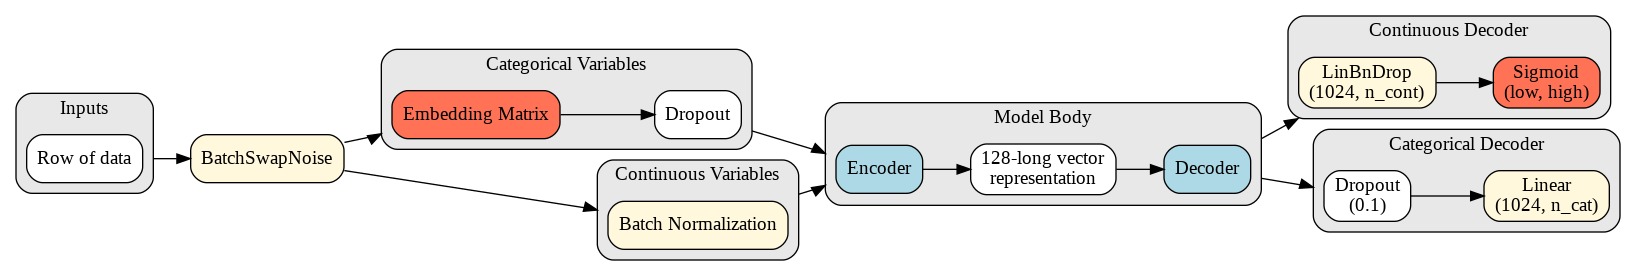

The base of this model is extremely similar to `fastai`'s `TabularModel`, minus a few distinctions:
* Our inputs immediatly pass through a `BatchSwapNoise` module, based on the [Porto Seguro Winning Solution](https://forums.fast.ai/t/porto-seguro-winning-solution-representation-learning/8499?page=2) which inputs random noise into our data for variability
* After going through the embedding matrix the "layers" of our model include an `Encoder` and `Decoder` (shown below) which compresses our data to a 128-long vector before blowing it back up in the decoder
* After outputted from the decoder we specifically decode the categorical and continuous variables back to their original shapes

### Encoder

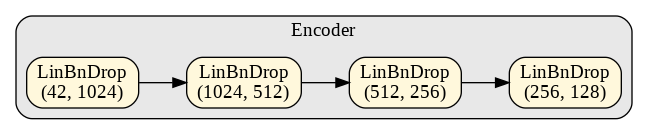

This encoder blows up our inputs (in this case) until we reach a 128-long vector representation. From there we pass it to the decoder (shown below):

### **Decoder**

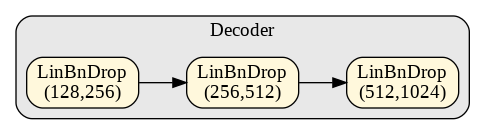

The decoder just does the reverse of what the encoder just did

## Building the Dataset

Since we are building a model that will be able to accurately recreate our data based on its input, we'll need a few modifications and special handles.

First let's setup the example Adult dataset:

In [ ]:
from fastai.tabular.all import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

Next we'll want our `cat_names`, `cont_names`, `procs`, etc:

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()
splits = RandomSplitter()(range_of(df))

And finally we'll get a baseline accuracy:

In [ ]:
to = TabularPandas(df, procs = [Categorify, FillMissing, Normalize], cat_names=cat_names, cont_names=cont_names, 
                   splits=splits, y_names=['salary'], y_block=CategoryBlock())

In [ ]:
dls = to.dataloaders(bs=1024)

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=[accuracy])
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.384204,0.416590,0.802058,00:00
1,0.363629,0.357684,0.831235,00:00
2,0.354959,0.365007,0.830927,00:00
3,0.349162,0.358973,0.831235,00:00
4,0.346052,0.366635,0.824478,00:00


## Custom Transforms and DataLoaders

Now we're going to go into how the API needs to be tweaked some in order to get this working.

### ReadTabBatchIdentity

`fastai` normally has `ReadTabBatch` as an `ItemTransform` in order to load in the outputs from a `TabularPandas` object. We need to modify this slightly, so instead of returning `x,y`, we return pairs of `x,x`:

In [ ]:
class ReadTabBatchIdentity(ItemTransform):
    "Read a batch of data and return the inputs as both `x` and `y`"
    def __init__(self, to): store_attr()

    def encodes(self, to):
        if not to.with_cont: res = (tensor(to.cats).long(),) + (tensor(to.cats).long(),)
        else: res = (tensor(to.cats).long(),tensor(to.conts).float()) + (tensor(to.cats).long(), tensor(to.conts).float())
        if to.device is not None: res = to_device(res, to.device)
        return res
    
class TabularPandasIdentity(TabularPandas): pass

### TabDataLoaderIdentity

Next we need a way to use our new transform, and that is through a new `DataLoader`:

In [ ]:
@delegates()
class TabDataLoaderIdentity(TabDataLoader):
    "A transformed `DataLoader` for AutoEncoder problems with Tabular data"
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms)+ReadTabBatchIdentity(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.iloc[b]

We also need to make `TabularPandasIdentity`'s `dl_type` to `TabDataLoaderIdentity` so it knows just what type of `DataLoader` to generate:

In [ ]:
TabularPandasIdentity._dl_type = TabDataLoaderIdentity

## Building the `TabularPandasIdentity`

Now we can build our `to` object and the `DataLoaders`:

In [ ]:
to = TabularPandasIdentity(df, [Categorify, FillMissing, Normalize], cat_names, cont_names, splits=RandomSplitter(seed=32)(df))
dls = to.dataloaders(bs=1024)

We'll set the `n_inp` to 2 and then work on building our loss function:

In [ ]:
dls.n_inp = 2

### Building Loss Function

Probably the most important part of this problem is creating a good loss function that can best measure how accurate our model could recreate the data. Let's look at how to approach this with categorical and continuous variables

For the categorical variables, we'll want to gather a dictionary of each unique possible class in it:

In [ ]:
total_cats = {k:len(v) for k,v in to.classes.items()}
total_cats

{'education': 17,
 'education-num_na': 3,
 'marital-status': 8,
 'occupation': 16,
 'race': 6,
 'relationship': 7,
 'workclass': 10}

We will then use this dictionary to figure out where to apply our `CrossEntropyLossFlat` for each categorical variable.

We'll also need to know the total number of outputs possible for those variables:

In [ ]:
sum([v for k,v in total_cats.items()])

67

For the continuous variables we need to know the means and standard deviations:

In [ ]:
to.means

{'age': 38.5793696495067,
 'education-num': 10.079158782958984,
 'fnlwgt': 190006.02011593536}

We're going to store the `means` and `stds` in a `DataFrame` to make some further adjustments before usage:

In [ ]:
means = pd.DataFrame.from_dict({k:[v] for k,v in to.means.items()})
stds = pd.DataFrame.from_dict({k:[v] for k,v in to.stds.items()})

That modification we will be making is gathering a sigmoid range based on the non-normalized data to reduce the range our values can be:

In [ ]:
low = (df[cont_names].min().to_frame().T.values - means.values) / stds.values
high = (df[cont_names].max().to_frame().T.values - means.values) / stds.values

In [ ]:
low, high

(array([[-1.57952443, -1.67843578, -3.55613996]]),
 array([[ 3.76378659, 12.22741736,  2.3190849 ]]))

### RecreatedLoss

Next we'll make our loss function. As mentioned, this loss function will run `MSELossFlat` on the continuous variables to measure accuracy and run `CrossEntropyLossFlat` for the categoricals:

In [ ]:
class RecreatedLoss(Module):
    "Measures how well we have created the original tabular inputs"
    def __init__(self, cat_dict):
        ce = CrossEntropyLossFlat(reduction='sum')
        mse = MSELossFlat(reduction='sum')
        store_attr('cat_dict,ce,mse')

    def forward(self, preds, cat_targs, cont_targs):
        cats, conts = preds
        tot_ce, pos = cats.new([0]), 0
        for i, (k,v) in enumerate(self.cat_dict.items()):
            tot_ce += self.ce(cats[:, pos:pos+v], cat_targs[:,i])
            pos += v
        
        norm_cats = cats.new([len(self.cat_dict)])
        norm_conts = conts.new([conts.size(1)])
        cat_loss = tot_ce/norm_cats
        cont_loss = self.mse(conts, cont_targs)/norm_conts
        total = cat_loss+cont_loss

        return total / cats.size(0)

And all we need to do is pass in our `total_cats` dictionary:

In [ ]:
loss_func = RecreatedLoss(total_cats)

## The Model

Next we'll work on building the model we showed earlier. First we need our `BatchSwapNoise` module:

In [ ]:
class BatchSwapNoise(Module):
    "Swap Noise Module"
    def __init__(self, p): store_attr()

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size()) > (1 - self.p)
            l1 = torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor)
            l2 = (mask.type(torch.LongTensor) * x.size(1))
            res = (l1 * l2).view(-1)
            idx = torch.arange(x.nelement()) + res
            idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
            return x.flatten()[idx].view(x.size())
        else:
            return x

Notice how it is like Dropout, where the noise is only added during training

Next we'll make a custom `TabularAE` model (AutoEncoder) for us to use:

In [ ]:
class TabularAE(TabularModel):
    "A simple AutoEncoder model"
    def __init__(self, emb_szs, n_cont, hidden_size, cats, low, high, ps=0.2, embed_p=0.01, bswap=None):
        super().__init__(emb_szs, n_cont, layers=[1024, 512, 256], out_sz=hidden_size, embed_p=embed_p, act_cls=Mish())
        
        self.bswap = bswap
        self.cats = cats
        self.activation_cats = sum([v for k,v in cats.items()])
        
        self.layers = nn.Sequential(*L(self.layers.children())[:-1] + nn.Sequential(LinBnDrop(256, hidden_size, p=ps, act=Mish())))
        
        if(bswap != None): self.noise = BatchSwapNoise(bswap)
        self.decoder = nn.Sequential(
            LinBnDrop(hidden_size, 256, p=ps, act=Mish()),
            LinBnDrop(256, 512, p=ps, act=Mish()),
            LinBnDrop(512, 1024, p=ps, act=Mish())
        )
        
        self.decoder_cont = nn.Sequential(
            LinBnDrop(1024, n_cont, p=ps, bn=False, act=None),
            SigmoidRange(low=low, high=high)
        )
        
        self.decoder_cat = LinBnDrop(1024, self.activation_cats, p=ps, bn=False, act=None)
        
    def forward(self, x_cat, x_cont=None, encode=False):
        if(self.bswap != None):
            x_cat = self.noise(x_cat)
            x_cont = self.noise(x_cont)
        encoded = super().forward(x_cat, x_cont)
        if encode: return encoded # return the representation
        decoded_trunk = self.decoder(encoded)
        decoded_cats = self.decoder_cat(decoded_trunk)
        decoded_conts = self.decoder_cont(decoded_trunk)
        return decoded_cats, decoded_conts

Towards the end we will look at how to extract our vector-representations, but those with keen-eyes can spot where it is in the above code. We can pass in an `encode=False` parameter to `forward`, and so long as we keep it to a `False` default, it will not break inside of the `fastai` training framework

Now let's build a model. We'll use a hidden layer size (vector representation) of 128, 10% dropout with 1% embedding dropout, 1% weight decay and a noise level of 10%. Along with this we will pass in our `y_range`:

In [ ]:
emb_szs = get_emb_sz(to.train)

In [ ]:
model = TabularAE(emb_szs, len(cont_names), 128, ps=0.1, cats=total_cats, embed_p=0.01,
                  bswap=.1, low=tensor(low).cuda(), high=tensor(high).cuda())

And finally our `Learner`:

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, wd=0.01, opt_func=ranger)

> Note: we are using the `ranger` optimizer here. During experiments we found it could train much better representations than Adam with fit/fit_one_cycle

And now we'll fit until we begin overfitting (with `EarlyStoppingCallback`):

In [ ]:
learn.fit_flat_cos(100, cbs=[EarlyStoppingCallback()], lr=4e-3)

epoch,train_loss,valid_loss,time
0,2.813770,1.659386,00:01
1,1.683434,1.029644,00:00
2,1.201613,0.390225,00:00
3,0.939611,0.192512,00:00
4,0.776153,0.164930,00:00
5,0.677212,0.123851,00:00
6,0.609503,0.131127,00:00


No improvement since epoch 5: early stopping


As we can see the best model was only after 6 epochs! Let's see how our representations stack up

## Getting the compressed representations

We're going to first gather the representations and grade them, before attempting to train a new classification model on the dataset.

To begin we need to make a new `DataLoader` with all of our data:

In [ ]:
dl = learn.dls.test_dl(df)

And then we will predict over all the data using raw `PyTorch`. Notice we are passing `encode=True` to grab the representations:

In [ ]:
outs = []
for batch in dl:
    with torch.no_grad():
        learn.model.eval()
        learn.model.cuda()
        out = learn.model(*batch[:2], encode=True).cpu().numpy()
        outs.append(out)
outs = np.concatenate(outs)

And now we can verify that it is indeed a 128-long vector:

In [ ]:
outs.shape

(32561, 128)

Finally we need the actual predictions and targets for the categorical and continuous variables:

In [ ]:
(cat_preds, cont_preds), (cat_targs, cont_targs) = learn.get_preds(dl=dl)

## Measuring the Accuracy of the Outputs

Next let's grade our models outputs to see just how close they were

### Continuous Variables

For measuring their overall accuracy we will use an `R2` score:

In [ ]:
cont_preds = pd.DataFrame(cont_preds, columns=cont_names)
cont_targs = pd.DataFrame(cont_targs, columns=cont_names)

We'll decode our values manually via our `stds` and `means`:

In [ ]:
preds = pd.DataFrame((cont_preds.values * stds.values) + means.values, columns=cont_preds.columns)
targets = pd.DataFrame((cont_targs.values * stds.values) + means.values, columns=cont_targs.columns)

And measure the `min`, `max`, `mean`, `median`, and `R2` score:

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
mi = (np.abs(targets-preds)).min().to_frame().T
ma = (np.abs(targets-preds)).max().to_frame().T
mean = (np.abs(targets-preds)).mean().to_frame().T
median = (np.abs(targets-preds)).median().to_frame().T
r2 = pd.DataFrame.from_dict({c:[r2_score(targets[c], preds[c])] for c in preds.columns})

In [ ]:
for d,name in zip([mi,ma,mean,median,r2], ['Min', 'Max', 'Mean', 'Median', 'R2']):
    d = d.insert(0, 'GroupBy', name)

Let's see how it looks:

In [ ]:
data = pd.concat([mi,ma,mean,median,r2])
data

,GroupBy,age,fnlwgt,education-num
0,Min,0.000059,0.978241,0.000016
0,Max,25.710478,184438.850185,3.531806
0,Mean,2.174467,29500.241901,0.302863
0,Median,1.651296,25012.966619,0.251093
0,R2,0.954096,0.876741,0.976418


Those `R2` values look very good! Let's take their mean:

In [ ]:
r2.mean(axis=1)

0    0.935752
dtype: float64

93.5% is not bad at all for 6 epochs! Let's take a look at the categorical variables next

### Categorical Variables

In [ ]:
cat_reduced = torch.zeros_like(cat_targs)
pos=0
for i, (k,v) in enumerate(total_cats.items()):
    cat_reduced[:,i] = cat_preds[:,pos:pos+v].argmax(dim=1)
    pos += v

cat_preds = pd.DataFrame(cat_reduced, columns=cat_names)
cat_targs = pd.DataFrame(cat_targs, columns=cat_names)

We'll measure a `balanced_accuracy` as well as an `f1_score`:

In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score

In [ ]:
accuracy = pd.DataFrame.from_dict({c:[balanced_accuracy_score(cat_targs[c], cat_preds[c])] for c in cat_preds.columns})

In [ ]:
f1 = pd.DataFrame.from_dict({c:[f1_score(cat_targs[c], cat_preds[c], average='weighted')] for c in cat_preds.columns})

In [ ]:
for d,name in zip([accuracy, f1], ['Accuracy', 'F1']):
    d = d.insert(0, 'MetricName', name)
pd.concat([accuracy, f1])

,MetricName,workclass,education,marital-status,occupation,relationship,race,education-num_na
0,Accuracy,0.767346,0.889644,0.710416,0.886990,0.982369,0.776148,0.945461
0,F1,0.995116,0.990894,0.975364,0.986651,0.994309,0.986774,0.998082


We can see that our accuracy is a *bit* lower than our continuous variables, but the F1 scores look very strong! 

Let's check the overall accuracy:

In [ ]:
accuracy.mean(axis=1)

0    0.851196
dtype: float64

85% is honestly quite good in this situation. Now let's take a look at how to *use* these representations

## Predicting

Now that we have our compressed representations, let's train a new model.

First we'll grab our `ys`:

In [ ]:
ys = df['salary'].to_numpy()

And make a dataframe that holds the representations and our `ys`:

In [ ]:
df_outs = pd.DataFrame(columns=['salary'] + list(range(0,128)))
df_outs['salary'] = ys
df_outs[list(range(0,128))] = outs
df_outs[list(range(0,128))] = df_outs[list(range(0,128))].astype(np.float16)

Next we'll make a new `TabularPandas` object and set it up exactly like we normally would for the `Adult` problem:

In [ ]:
cont_names = list(range(0,128))
splits = RandomSplitter()(range_of(df))
to = TabularPandas(df_outs, procs = [Normalize], cont_names=cont_names, splits=splits, y_names=['salary'], reduce_memory=False, 
                   y_block=CategoryBlock())

Build our `DataLoaders`:

In [ ]:
dls = to.dataloaders(bs=1024)

And then train
> We need to redefine `accuracy` since currently it holds a `DataFrame`

In [ ]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=[accuracy])

In [ ]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.388640,0.365884,0.829238,00:00
1,0.365857,0.354237,0.835227,00:00
2,0.356470,0.358809,0.839527,00:00
3,0.352679,0.356664,0.839834,00:00
4,0.348162,0.356980,0.839681,00:00


And we can see our model achieved a *better* accuracy than the original data!
> Note: a fastai model can achieve ~84%, however in this instance it outperformed the baseline model